# Write READABLE code

# Import Libraries

In [1]:
import os

import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import KFold

import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import Input, Reshape, Dense, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import SpatialDropout2D, Dropout
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.backend import flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.callbacks import ReduceLROnPlateau, TensorBoard, ModelCheckpoint, EarlyStopping


# Loading Dataset

In [2]:
# load dataset
(trainX, trainY), (testX, testY) = fashion_mnist.load_data()

# EDA

In [3]:
labels = np.array([np.argmax(i) for i in trainY])
classes, counts = np.unique(labels,return_counts=True)

for i,j in zip(classes,counts):
    print(f"class : {i}, number_of_images : {j} ")
print()
print("There is no Class imbalance")

class : 0, number_of_images : 60000 

There is no Class imbalance


In [4]:
# summarize loaded dataset
print('Train: X=%s, y=%s' % (trainX.shape, trainY.shape))
print('Test: X=%s, y=%s' % (testX.shape, testY.shape))

Train: X=(60000, 28, 28), y=(60000,)
Test: X=(10000, 28, 28), y=(10000,)


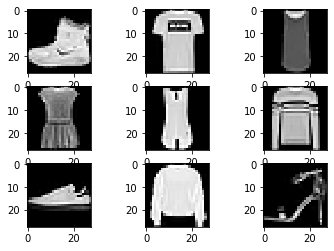

In [5]:
# plot first few images
for i in range(9):
    plt.subplot(330 + 1 + i)
    plt.imshow(trainX[i], cmap=plt.get_cmap('gray'))

plt.show()

# Preparing Data

## Convert data to vectors

In [6]:
# Train data
trainX = np.array(trainX, dtype=np.float32)
trainX = trainX.reshape(trainX.shape[0], trainX.shape[1], trainX.shape[2], -1)

trainY = np.array(trainY, dtype=np.float32)
trainY = trainY.reshape(trainY.shape[0], -1)
trainY = to_categorical(trainY)

# Test data
testX = np.array(testX, dtype=np.float32)
testX = testX.reshape(testX.shape[0], testX.shape[1], testX.shape[2], -1)

testY = np.array(testY, dtype=np.float32)
testY = testY.reshape(testY.shape[0], -1)
testY = to_categorical(testY)

## Normalize data

In [7]:
trainX /= 255.
testX /= 255.

# Custom Neural Network

In [8]:
def custom_net(input_shape,
               num_classes=10,
               learning_rate=0.001,
               metrics=['accuracy']):
    """
    
    
    Reference:
        [1] https://machinelearningmastery.com/how-to-develop-a-cnn-from-scratch-for-fashion-mnist-clothing-classification/
        [2] https://www.kaggle.com/bugraokcu/cnn-with-keras
    """
    inputs = Input(shape=input_shape)

    # conv block 1
    conv1 = Conv2D(filters=32,
                   kernel_size=(3, 3),
                   activation='relu',
                   padding='same',
                   name='conv1')(inputs)
    pool1 = MaxPooling2D(pool_size=(2, 2), name='pool1')(conv1)

    dropout1 = Dropout(0.25, name='dropout1')(pool1)

    # conv block 2
    conv2 = Conv2D(filters=64,
                   kernel_size=(3, 3),
                   activation='relu',
                   padding='same',
                   name='conv2')(dropout1)
    pool2 = MaxPooling2D(pool_size=(2, 2), name='pool2')(conv2)

    dropout2 = Dropout(0.3, name='dropout2')(pool2)

    # conv block 3
    conv3 = Conv2D(filters=128,
                   kernel_size=(3, 3),
                   activation='relu',
                   padding='same',
                   name='conv3')(dropout2)
    pool3 = MaxPooling2D(pool_size=(2, 2), name='pool3')(conv3)
    dropout3 = Dropout(0.3, name='dropout3')(pool3)

    # dense block 1
    x1 = Flatten(name='flatten1')(dropout3)
    dropout4 = Dropout(0.2, name='dropout4')(x1)
    dense1 = Dense(units=128, activation='relu', name='dense1')(dropout4)
    dropout5 = Dropout(0.2, name='dropout5')(dense1)
    dense2 = Dense(units=num_classes, activation='softmax' , name='dense2')(dropout5)

    model = Model(inputs=[inputs], outputs=[dense2])

    model.compile(optimizer=Adam(learning_rate=learning_rate),
                  loss=categorical_crossentropy,
                  metrics=metrics)
    return model


# Network parameters
num_classes = 10
img_rows, img_cols = 28, 28
input_shape = (img_rows, img_cols, 1)

metrics = ['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]

lr = 0.0001
model = custom_net(input_shape=input_shape,
                   num_classes=num_classes,
                   learning_rate=lr,
                   metrics=metrics)
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 28, 28, 32)        320       
_________________________________________________________________
pool1 (MaxPooling2D)         (None, 14, 14, 32)        0         
_________________________________________________________________
dropout1 (Dropout)           (None, 14, 14, 32)        0         
_________________________________________________________________
conv2 (Conv2D)               (None, 14, 14, 64)        18496     
_________________________________________________________________
pool2 (MaxPooling2D)         (None, 7, 7, 64)          0         
_________________________________________________________________
dropout2 (Dropout)           (None, 7, 7, 64)          0     

# Load earlier model

In [9]:
model.load_weights("./checkpoints/fit4/model-05-0.93-0.93.h5", by_name=True)

# Fit model

In [10]:
epochs = 30
batch_size = 256
train_session = 5


if not os.path.exists(f"./checkpoints/fit{train_session}"):
    os.makedirs(f"./checkpoints/fit{train_session}")
    
checkpoints_filepath = f"./checkpoints/fit{train_session}" + "/model-{epoch:02d}-{accuracy:.4f}-{val_accuracy:.4f}.h5"

callbacks = [
    TensorBoard(log_dir=f"./logs/fit{train_session}/"),
    ModelCheckpoint(filepath=checkpoints_filepath,
                    save_weights_only=True,
                    monitor='val_accuracy',
                    mode='max',
                    save_best_only=True),
    EarlyStopping(monitor='val_loss', patience=8),
    ReduceLROnPlateau(monitor='val_accuracy', patience=7)
]

history = model.fit(trainX,
                    trainY,
                    validation_split=0.30,
                    epochs=epochs,
                    batch_size=batch_size,
                    callbacks=callbacks)

Train on 42000 samples, validate on 18000 samples
Epoch 1/30
42000/42000 [==============================] - 31s 731us/sample - loss: 0.1979 - accuracy: 0.9256 - precision: 0.9362 - recall: 0.9155 - val_loss: 0.1965 - val_accuracy: 0.9299 - val_precision: 0.9406 - val_recall: 0.9209
Epoch 2/30
42000/42000 [==============================] - 26s 623us/sample - loss: 0.1924 - accuracy: 0.9273 - precision: 0.9379 - recall: 0.9184 - val_loss: 0.2070 - val_accuracy: 0.9239 - val_precision: 0.9346 - val_recall: 0.9149
Epoch 3/30
42000/42000 [==============================] - 26s 631us/sample - loss: 0.1923 - accuracy: 0.9267 - precision: 0.9369 - recall: 0.9168 - val_loss: 0.1966 - val_accuracy: 0.9303 - val_precision: 0.9382 - val_recall: 0.9236
Epoch 4/30
42000/42000 [==============================] - 26s 618us/sample - loss: 0.1931 - accuracy: 0.9275 - precision: 0.9374 - recall: 0.9187 - val_loss: 0.1990 - val_accuracy: 0.9287 - val_precision: 0.9389 - val_recall: 0.9206
Epoch 5/30
42000/4

# Load best model weights

In [21]:
# latest model of a train session has best model weights
# eg. if ./checkpoints/fit5 is the latest folder latest entry in it has best weights
model.load_weights("./checkpoints/fit5/model-15-0.94-0.94.h5")

# Test model on best weights

In [22]:
test_eval_results = model.evaluate(testX, testY, batch_size=batch_size)

10000/10000 [==============================] - 2s 206us/sample - loss: 0.2000 - accuracy: 0.9291 - precision: 0.9373 - recall: 0.9231


In [23]:
test_loss, test_accuracy, test_precision, test_recall = test_eval_results
print(f"Test Accuracy  {test_accuracy:0>.4f}")
print(f"Test loss      {test_loss:0>.4f}")
print(f"Test Precision {test_precision:0>.4f}")
print(f"Test Recall    {test_recall:0>.4f}")

Test Accuracy  0.9291
Test loss      0.2000
Test Precision 0.9373
Test Recall    0.9231


# Saving model

In [35]:
model.save("../models/custom_model_94_92.h5") # modelName_trainAccuracy_testAccuracy